# 👁️ Convolutional Neural Networks (CNNs)

[Deep Learning](https://dsai.units.it/index.php/courses/deep-learning/) Course @ [UniTS](https://portale.units.it/en), Spring 2024

<a target="_blank" href="https://colab.research.google.com/github/emaballarin/deeplearning-units/blob/main/labs/04_convolutional.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>  <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/emaballarin/deeplearning-units/blob/main/labs/04_convolutional.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

## Introduction

Convolutional Neural Networks (CNNs) are a staple architecture in the field of (*deep-learning-based*) Computer Vision, and the go-to choice for visual tasks, *e.g.* image classification, segmentation and recognition among the many.

The main advantages of CNNs lie in the use of a *Convolutional Layer*, exhibiting a **position-invariant** inductive bias and very limited learnable parameter count compared to equivalent FC models. This allows CNNs to learn hierarchical features from the input data, and to generalize better to unseen data.

## The building blocks of a CNN

The essential building blocks of convolutional neural networks are the following.


### Convolutional layers

The basic building block of a CNN is - indeed - the **convolutional layer**, available in PyTorch as `torch.nn.Conv<s>d`, where `<s>` represents the number of **spatial dimensions** of our data. *I.e.:*

* `Conv1d` for $1$-dimensional sequences. *Example*: audio. Audio is organized as a sequence of a given length (the single spatial dimension), where each single value in this sequence represent the intensity/amplitude of the signal for a given sampled time point. Audio data can be organized in multiple **channels** (e.g., stereo data has 2 channels). The convolution operation is represented by a one-dimensional kernel;

* `Conv2d` for 2 dimensional data, like images (where the two dimensions are **spatial** dimensions, *e.g.* height and width);
* 
* `Conv3d` for 3 dimensional data. *Example*: a 3D reconstruction obtained from a 2D image. A convolution in that domain might equate to sliding a cubic kernel along all three dimensions.

#### (Some) parameters for constructors

```python
Conv2d(in_channels: int, out_channels: int, kernel_size: Union[int, Tuple[int, int]], stride: Union[int, Tuple[int, int]] = 1, padding: Union[int, Tuple[int, int]] = 0)
```
* `in_channels`: the number of channels (planes) of the incoming data;
* `out_channels`: the number of channels (planes) of the desired output data, *i.e.*, the number of convolutions that are performed;
* `kernel_size`: the kernel size of each convolution. An int $k$ is interpreted as the tuple $(k, k)$ (i.e., a square kernel); for a rectangular kernel, pass a tuple explicitly.
* `stride`: the step size used when moving the kernel on the input data, along each dimension. An int $s$ is interpreted as the tuple $(s, s)$ (i.e., an isotropic kernel); for an anisotropic stride, pass a tuple explicitly;
* `padding`: if set to $>0$, the incoming image is enlarged with `padding` rows and columns of zeros (unless otherwise specified).

To visualize these and other parameters and how they affect the convolution operation, you can have a look at [this page](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md).

Note that a convolution does **NOT** require to specify a spatial dimension as input/output, as convolution is oblivious to these factors!

To better visualize how convolutions work with multi-channel data, have a look at [this](https://www.coursera.org/lecture/convolutional-neural-networks/convolutions-over-volume-ctQZz) short video by Andrew Ng.

### Preliminary infrastucture setup

Nothing new here, just the usual cloud-aware setup...

In [1]:
import os

FOLDERNAME: str = "deeplearning_units_2024"
try:
    if os.getenv("COLAB_RELEASE_TAG"):
        # noinspection PyUnresolvedReferences
        from google.colab import drive

        drive.mount(BASEPATH := "/content/drive")
        os.makedirs(FULLPATH := BASEPATH + "/MyDrive/" + FOLDERNAME, exist_ok=True)
    elif os.getenv("KAGGLE_CONTAINER_NAME"):
        os.makedirs(FULLPATH := "/kaggle/working/" + FOLDERNAME, exist_ok=True)
    else:
        os.makedirs(FULLPATH := "./" + FOLDERNAME, exist_ok=True)
    os.chdir(FULLPATH)
except (ModuleNotFoundError, FileExistsError, FileNotFoundError):
    pass

### The imports for the day

In [2]:
import torch as th
from torch import nn
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import torchvision as tv

from typing import Union, Callable
from tqdm import trange
from typing import List

from ebtorch.nn.utils import eval_model_on_test
from ebtorch.nn.utils import extract_conv_filters, show_filters

from safetensors.torch import save_model, load_model

#### A simple example

In [3]:
conv_layer_example: nn.Conv2d = th.nn.Conv2d(
    in_channels=3, out_channels=32, kernel_size=3
)
print(
    "Parameters of convolution\n",
    "\tWeights\n",
    conv_layer_example.weight.shape,
    "\n\tBias\n",
    conv_layer_example.bias.shape,
)

Parameters of convolution
 	Weights
 torch.Size([32, 3, 3, 3]) 
	Bias
 torch.Size([32])


In [4]:
# Conv2d is applied independently of the input spatial dimension
y: Tensor = conv_layer_example(th.rand(1, 3, 10, 10))
print("Output shape\n", y.shape)

Output shape
 torch.Size([1, 32, 8, 8])


In [5]:
z: Tensor = conv_layer_example(th.rand(1, 3, 6, 6))
print("Output shape\n", z.shape)

Output shape
 torch.Size([1, 32, 4, 4])


### Pooling layers

*Pooling layers* are essentially convolutions **without trainable kernels**. For each overlap between the image and the kernel, they output the maximum ($\rightarrow$ _maxpooling_) or the average ($\rightarrow$ _avgpooling_), *etc...* of the image in that specific region.

![](https://production-media.paperswithcode.com/methods/MaxpoolSample2.png)

#### (Some) parameters for constructors

```MaxPool2d(kernel_size: Union[int, Tuple[int, ...]], stride: Union[int, Tuple[int, ...], NoneType] = None, padding: Union[int, Tuple[int, ...]] = 0)```

Notice that now we do not have nthe need to pass input or output channels as parameter, because *Max/Avg/...* Pooling act independently on each channel, so `in_channels=out_channels`!

#### Adaptive Pooling

Adaptive (*Max/Avg/...*) Pooling is still a pooling layer, parameterised by the option to specify the **desired spatial dimension** of the output instead of parameters like *kernel size*, *padding*, *etc., ...*.

PyTorch works out by itself the parameters required in order for the pooling to produce an output of the desired size.

The most common application of this layer is (maybe) when operating the channel-wise average pooling at the end of a cascade of convolutional layers. In this case, we specify a fixed size of $(1,1)$, such that PyTorch will essentially operate an average of each whole channel.

In [ ]:
aavgpool: nn.AdaptiveAvgPool2d = th.nn.AdaptiveAvgPool2d(output_size=(1, 1))
print(aavgpool(th.rand(1, 3, 32, 32)).shape)

### Flattening

The last crucial *layer* in a CNN is the **flattening** *layer* (more of an *operation*, which induces a **reshaping** of the data from a multi-dimensional tensor to a 1D tensor. This is required in order to feed it to a final fully connected layer.

In [ ]:
print("Before flattening\n", th.rand(1, 3, 32, 32).shape)
print("After flattening\n", th.nn.Flatten()(th.rand(1, 3, 32, 32)).shape)

## Building a CNN

The *typical model training* pipeline will be exactly the same as in the previous labs (*e.g.* that on gradient-based training of a FCN on the MNIST dataset), with the only differences being the **dataset** and **model architecture**.

In [6]:
# Hyperparameters
DEVICE_AUTODETECT: bool = True
TRAIN_BATCH_SIZE: int = 64
TEST_BATCH_SIZE: int = 1000
EPOCHS: int = 15
CRITERION: Union[th.nn.Module, Callable[[th.Tensor], th.Tensor]] = (
    th.nn.CrossEntropyLoss(reduction="mean")
)
EVAL_CRITERION: Union[th.nn.Module, Callable[[th.Tensor], th.Tensor]] = (
    th.nn.CrossEntropyLoss(reduction="sum")
)
LR: float = 2e-3

In [7]:
# Device setup
device: th.device = th.device(
    "cuda" if th.cuda.is_available() and DEVICE_AUTODETECT else "cpu"
)

#### The data

In [8]:
cifarten_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
    ]
)

os.makedirs("./data/", exist_ok=True)

train_dataset = datasets.CIFAR10(
    root="./data", train=True, transform=cifarten_transforms, download=True
)
test_dataset = datasets.CIFAR10(
    root="./data", train=False, transform=cifarten_transforms, download=True
)

train_loader: DataLoader = DataLoader(
    dataset=train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True
)
test_loader: DataLoader = DataLoader(
    dataset=test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False
)

100%|██████████| 170498071/170498071 [00:08<00:00, 21289247.95it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let's have a look at the data we just loaded.

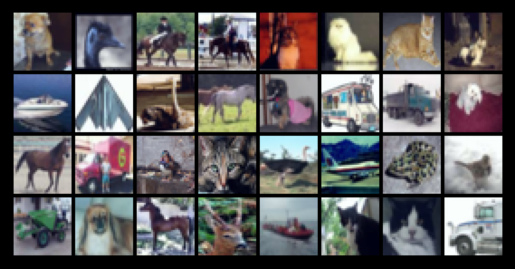

In [9]:
def imshow(img) -> None:
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, axes=(1, 2, 0)))


# Get some random training images
dataiter = train_loader.__iter__()
images, labels = dataiter.__next__()

# Show grid of images
imshow(tv.utils.make_grid(images[: 8 * 4], normalize=True))

In [10]:
# Let's see the associated labels
print(f"Labels: {labels[:8*4]}")

Labels: tensor([5, 2, 7, 7, 3, 3, 3, 3, 8, 0, 2, 7, 5, 9, 9, 5, 7, 9, 2, 3, 2, 0, 6, 2,
        9, 5, 7, 4, 8, 3, 3, 9])


In [11]:
# Let's see the shape of the images
print(f"Images shape: {images.shape}")

Images shape: torch.Size([64, 3, 32, 32])


In [12]:
class MyCNN(th.nn.Module):
    def __init__(self, cls_out: int = 10) -> None:
        super().__init__()

        self.conv = th.nn.Sequential(
            th.nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0
            ),
            th.nn.Mish(),
            th.nn.MaxPool2d(kernel_size=2),
            th.nn.Dropout(p=0.2),
            th.nn.Conv2d(
                in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1
            ),
            th.nn.Mish(),
            th.nn.MaxPool2d(kernel_size=2, stride=1),
            th.nn.Flatten(),
        )

        self.head = th.nn.Linear(392, cls_out)

    def forward(self, x: Tensor) -> Tensor:
        return self.head(self.conv(x))

In [13]:
model: MyCNN = MyCNN().to(device)
model.train()

MyCNN(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): Mish()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): Mish()
    (6): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
  )
  (head): Linear(in_features=392, out_features=10, bias=True)
)

In [14]:
# Let's define the optimizer
optimizer: th.optim.Optimizer = th.optim.Adam(
    params=model.parameters(), lr=LR, weight_decay=0
)

In [15]:
eval_losses: List[float] = []
eval_acc: List[float] = []
test_acc: List[float] = []

# Loop over epochs
for epoch in trange(EPOCHS, desc="Training epoch"):

    model.train()  # Remember to set the model in training mode before actual training

    # Loop over data
    for batch_idx, batched_datapoint in enumerate(train_loader):

        x, y = batched_datapoint
        x, y = x.to(device), y.to(device)

        # Forward pass + loss computation
        yhat = model(x)
        loss = CRITERION(yhat, y)

        # Zero-out past gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

    # Log the loss and accuracy on the training set...
    num_elem: int = 0
    trackingmetric: float = 0
    trackingcorrect: int = 0

    model.eval()  # Remember to set the model in evaluation mode before evaluating it

    # Since we are just evaluating the model, we don't need to compute gradients
    with th.no_grad():
        # ... by looping over training data again
        for _, batched_datapoint_e in enumerate(train_loader):
            x_e, y_e = batched_datapoint_e
            x_e, y_e = x_e.to(device), y_e.to(device)
            modeltarget_e = model(x_e)
            ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
            trackingmetric += EVAL_CRITERION(modeltarget_e, y_e).item()
            trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
            num_elem += x_e.shape[0]
        eval_losses.append(trackingmetric / num_elem)
        eval_acc.append(trackingcorrect / num_elem)

    # Let's ignore for now what the next line does... 🙈
    test_acc.append(
        eval_model_on_test(
            model, True, test_loader, device, th.nn.CrossEntropyLoss(), False
        )
    )

Training epoch:  20%|██        | 3/15 [03:02<12:08, 60.69s/it]


KeyboardInterrupt: 

In [ ]:
loss_color = "tab:red"
acc_color = "tab:blue"

fig, ax1 = plt.subplots()

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=loss_color)
ax1.plot(eval_losses, color=loss_color)
ax1.tick_params(axis="y", labelcolor=loss_color)

ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color=acc_color)
ax2.plot(eval_acc, color=acc_color)
ax2.tick_params(axis="y", labelcolor=acc_color)

fig.tight_layout()

plt.title("Training loss and accuracy")
plt.show()

In [ ]:
print(f"Final training loss: {eval_losses[-1]}")
print(f"Final training accuracy: {eval_acc[-1]}")

In [ ]:
# Let's plot the accuracy on the train vs test set

fig, ax = plt.subplots()

ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.plot(eval_acc, label="Train", color="tab:blue")
ax.plot(test_acc, label="Test", color="tab:orange")
ax.legend()

plt.title("Training vs. Test accuracy")
plt.show()

In [ ]:
print(f"Final test accuracy: {test_acc[-1]}")

Our (relatively simple) CNN is definitely performing better than what a similar MLP would have obtained in such task (within the same training length).

Somehow counterintuitively, the number of parameters of our current model is much smaller than of that hypothetical MLP.

What really makes CNNs so good at CV tasks **is not the model complexity** (number of parameters), **but the inductive bias they produce**!

In [ ]:
def get_params_num(net: nn.Module) -> int:
    return sum(map(th.numel, net.parameters()))

In [ ]:
get_params_num(model)

In [ ]:
save_model(model, "cifar10_model.safetensors")
save_model(model.conv, "cifar10_featurizer.safetensors")

## Transfer Learning

In Deep Learning practice, people rarely train **large** models from scratch (*i.e.* from randomly initialized weights). This is especially true in Computer Vision (or Language Modelling!), where *pre-trained* weights for many *standard* models are openly available.

In the usual setting, when facing a Computer Vision task (unless for some reason you want to use a customized architecture!), you load a pre-trained model and **fine-tune** it.

Fine-tuning can follow different paths: one possibility is to freeze all the layers of the network excluding the last (the classification head), another is to train the whole end-to-end classifier starting from pre-trained weights.

### A feature-freezing example

As an example, we will try to re-use the features learned by our previously trained network (which was trained on CIFAR-10) on the much more complex CIFAR-100 dataset. The results will be surely unsatisfactory, but the point here is to show how to proceed.

In [ ]:
cifarhundred_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
    ]
)

os.makedirs("./data/", exist_ok=True)

train_dataset_new = datasets.CIFAR100(
    root="./data", train=True, transform=cifarhundred_transforms, download=True
)
test_dataset_new = datasets.CIFAR100(
    root="./data", train=False, transform=cifarhundred_transforms, download=True
)

train_loader_new: DataLoader = DataLoader(
    dataset=train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True
)
test_loader_new: DataLoader = DataLoader(
    dataset=test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False
)

In [ ]:
def imshow(img) -> None:
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, axes=(1, 2, 0)))


# Get some random training images
dataiter = train_loader.__iter__()
images, labels = dataiter.__next__()

# Show grid of images
imshow(tv.utils.make_grid(images[: 8 * 4], normalize=True))

In [ ]:
# Let's see the associated labels
print(f"Labels: {labels[:8*4]}")

In [ ]:
# Let's see the shape of the images
print(f"Images shape: {images.shape}")

In [ ]:
model_new: MyCNN = MyCNN(cls_out=100).to(device)
model_new.train()

In [ ]:
def zero_grad_otf(base_model: nn.Module, learnable_name: str = "head") -> None:
    for name, param in base_model.named_parameters():
        if learnable_name not in name:
            param.grad = None
            param.requires_grad = False

In [ ]:
load_model(model_new.conv, "cifar10_featurizer.safetensors")

In [ ]:
zero_grad_otf(model_new, "head")

In [ ]:
# Let's define the optimizer
optimizer_new: th.optim.Optimizer = th.optim.Adam(
    params=model_new.parameters(), lr=LR, weight_decay=0
)

In [ ]:
eval_losses_new: List[float] = []
eval_acc_new: List[float] = []
test_acc_new: List[float] = []

for epoch in trange(EPOCHS, desc="Training epoch"):

    model_new.train()  # Remember to set the model_new in training mode before actual training

    # Loop over data
    for batch_idx, batched_datapoint in enumerate(train_loader_new):

        x, y = batched_datapoint
        x, y = x.to(device), y.to(device)

        zero_grad_otf(model_new, "head")  # Ensure that only the head is trained
        yhat = model_new(x)
        loss = CRITERION(yhat, y)

        optimizer_new.zero_grad()

        loss.backward()

        optimizer_new.step()

    num_elem: int = 0
    trackingmetric: float = 0
    trackingcorrect: int = 0

    model_new.eval()

    with th.no_grad():
        for _, batched_datapoint_e in enumerate(train_loader_new):
            x_e, y_e = batched_datapoint_e
            x_e, y_e = x_e.to(device), y_e.to(device)
            model_target_e = model_new(x_e)
            ypred_e = th.argmax(model_target_e, dim=1, keepdim=True)
            trackingmetric += EVAL_CRITERION(model_target_e, y_e).item()
            trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
            num_elem += x_e.shape[0]
        eval_losses_new.append(trackingmetric / num_elem)
        eval_acc_new.append(trackingcorrect / num_elem)

    test_acc_new.append(
        eval_model_on_test(
            model_new, True, test_loader_new, device, th.nn.CrossEntropyLoss(), False
        )
    )

In [ ]:
loss_color = "tab:red"
acc_color = "tab:blue"

fig, ax1 = plt.subplots()

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=loss_color)
ax1.plot(eval_losses_new, color=loss_color)
ax1.tick_params(axis="y", labelcolor=loss_color)

ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color=acc_color)
ax2.plot(eval_acc_new, color=acc_color)
ax2.tick_params(axis="y", labelcolor=acc_color)

fig.tight_layout()

plt.title("Training loss and accuracy")
plt.show()

In [ ]:
print(f"Final training loss: {eval_losses_new[-1]}")
print(f"Final training accuracy: {eval_acc_new[-1]}")

In [ ]:
# Let's plot the accuracy on the train vs test set

fig, ax = plt.subplots()

ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.plot(eval_acc_new, label="Train", color="tab:blue")
ax.plot(test_acc_new, label="Test", color="tab:orange")
ax.legend()

plt.title("Training vs. Test accuracy")
plt.show()

In [ ]:
print(f"Final test accuracy: {test_acc_new[-1]}")

##### Visualising the features

Let's have a look at the filters learned by the first convolutional layer of our model.

In [ ]:
conv1_filters: th.Tensor = extract_conv_filters(model_new.conv[0])
show_filters(conv1_filters)
conv1_filters.shape

### Fine-tuning

The procedure required by network *fine-tuning* is indeed simpler that that required for *feature freezing*. We just need to load the weights obtained from the previously-learnt (whole!) model and train the network end-to-end.

## Transposed Convolutions

Transpose Convolutions follow a working principle that is very similar to that of *normal* Convolutions, but they are used to generate an image starting from some *features* instead of the reverse.

The parameters to construct a Transposed Convolutional layer are exactly the same as for Convolutional layers:

```python
ConvTranspose2d(in_channels: int, out_channels: int, kernel_size: Union[int, Tuple[int, int]], stride: Union[int, Tuple[int, int]] = 1, padding: Union[int, Tuple[int, int]] = 0)
```
However, note that the meaning of some of these parameters may be counterintuitive, since its meaning will be **reversed** *w.r.t.* that used for *standard* convolutions!

[Example with `stride=2`, `kernel_size=3`, `padding=0`.](https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/no_padding_strides_transposed.gif)

[Example with `stride=2`, `kernel_size=3`, `padding=1`.](https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/padding_strides_transposed.gif)


Transposed Convolutions can be used to build *autoencoders* and *GANs* - among the many - instrumental in order to build **generative models** capable of image-data generation.